In [1]:
from __future__ import print_function
%matplotlib inline
import os
from collections import OrderedDict
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn.metrics import classification_report
from skimage.util import random_noise
import decimal
import captum
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
import pandas as pd
import datetime
import random
from IPython.display import clear_output
from dateutil.parser import parse
from random import randrange
from statistics import mean
import seaborn as sns
import sys
import pickle
import math
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/")
import utils
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/adunetae")
from model import Generator,Discriminator
from utils import weights_init,gradient_penalty
import pdb

In [2]:
tag = 'p0005'
ngpu = 1
nc = 1
batch_size = 256
lr = 1e-4
lambda_gp = 10
critic_iterations = 5
# weight_clip = 0.01

outpath = '/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/adunetae/'

In [3]:
train = np.load('/home/rgopikrishna/data/noisereduced/train_0005.npy')

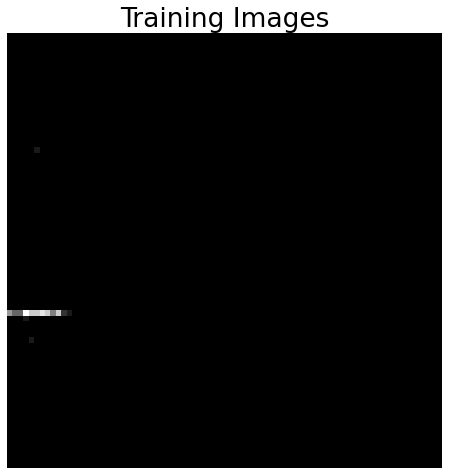

In [4]:
# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:3" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0,0], padding=2,normalize=True).cpu(),(1,2,0)))

In [5]:
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0,0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0,0.9))

In [6]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
critic_real_val = []
critic_fake_val = []
reconstructionerror = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
#     clear_output(wait=True)
    fakes = []
    inputs = []
    fake_lastitem = None
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_train):
        
        dataBatchX = Variable(data[:,0,:].unsqueeze(1).float()).to(device)
        inputs.append(dataBatchX.cpu().data.numpy())
        
        # Update discriminator
        for idx,_ in enumerate(range(critic_iterations)):
            noise = torch.randn(dataBatchX.size(0),1, 10, 10, device=device)
            fake = netG(noise,dataBatchX)
            if idx==critic_iterations-1:
                fakes.append(fake.cpu().data.numpy())
            critic_real = netD(dataBatchX).reshape(-1)
            critic_fake = netD(fake).reshape(-1) 
            gp = gradient_penalty(netD, dataBatchX, fake, device=device)
            lossD = (-(torch.mean(critic_real) - torch.mean(critic_fake))) + lambda_gp*gp
            critic_real_val = torch.mean(critic_real).item()
            critic_fake_val = torch.mean(critic_fake).item()
            netD.zero_grad()
            lossD.backward(retain_graph = True)
            optimizerD.step()

        # Update Generator
        output = netD(fake).reshape(-1)
        lossG = -torch.mean(output)
        netG.zero_grad()
        lossG.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d] - Loss G: %.4f, Loss D: %.4f, critic(real):%.4f, critic(fake):%.4f' % (epoch+1,num_epochs,lossG.item(),lossD.item(),critic_real_val,critic_fake_val))
        
        fig,ax = plt.subplots(1,2,figsize=(10,5))
        ax[1].imshow(fake[0,0].cpu().data.numpy())
        ax[0].imshow(dataBatchX[0,0].cpu().data.numpy())
        fig.savefig(outpath + 'images/generatedimages/realfake_epoch_{}.png'.format(epoch))
        plt.close()
        
        # Save Losses for plotting later
    G_losses.append(lossG.item())
    D_losses.append(lossD.item())
    
    if epoch % 5 == 0:
        torch.save(netG.state_dict(),outpath + '/models/g_fm_{}_{}.pth'.format(str(datetime.date.today()),tag))
        torch.save(netD.state_dict(),outpath + '/models/d_fm_{}_{}.pth'.format(str(datetime.date.today()),tag))
        print('Saving model..')
        
fakes = np.concatenate(fakes)
inputs = np.concatenate(inputs)

Starting Training Loop...
[1/100] - Loss G: 0.1912, Loss D: 26141.7695, critic(real):-0.6187, critic(fake):-0.1670
Saving model..
[2/100] - Loss G: -1.2808, Loss D: 9.0758, critic(real):1.2639, critic(fake):1.2841
[3/100] - Loss G: -0.9728, Loss D: 2.8972, critic(real):1.2706, critic(fake):0.9807
[4/100] - Loss G: -0.5926, Loss D: 0.5103, critic(real):1.0509, critic(fake):0.5747
[5/100] - Loss G: -0.3479, Loss D: 1.0181, critic(real):0.9484, critic(fake):0.4079
[6/100] - Loss G: -0.0378, Loss D: -0.3360, critic(real):0.8839, critic(fake):-0.0363
Saving model..
[7/100] - Loss G: -0.0975, Loss D: 0.0759, critic(real):1.0320, critic(fake):0.2345
[8/100] - Loss G: 0.0342, Loss D: -0.3281, critic(real):0.8252, critic(fake):-0.0619
[9/100] - Loss G: -0.3437, Loss D: 0.7853, critic(real):0.8982, critic(fake):0.2430
[10/100] - Loss G: 0.2724, Loss D: -0.4052, critic(real):0.7249, critic(fake):-0.2590
[11/100] - Loss G: -0.0226, Loss D: 0.3074, critic(real):0.6710, critic(fake):0.0299
Saving mo

In [7]:
print(len(inputs),len(fakes))
np.save(outpath + 'images/generatedimages/numpys/fake_{}_train_{}.npy'.format(str(datetime.date.today()),tag),fakes)
np.save(outpath + 'images/generatedimages/numpys/real_{}_train_{}.npy'.format(str(datetime.date.today()),tag),inputs)

11670 11670


In [8]:
pd.Series(D_losses)[:30]

0     19.270206
1      1.980730
2      0.431794
3      0.363029
4      0.418642
5     -0.181115
6     -0.013911
7      0.255351
8     -0.206965
9      1.156577
10     0.425493
11     0.054727
12    -0.440570
13    -0.408882
14    -0.117602
15    -0.138953
16    -0.125362
17    -0.162546
18     0.035776
19    -0.062456
20    -0.243253
21     3.153993
22    -0.055326
23    -0.066785
24     0.033456
25     0.003877
26     0.033072
27    -0.069777
28    -0.031852
29    -0.071814
dtype: float64

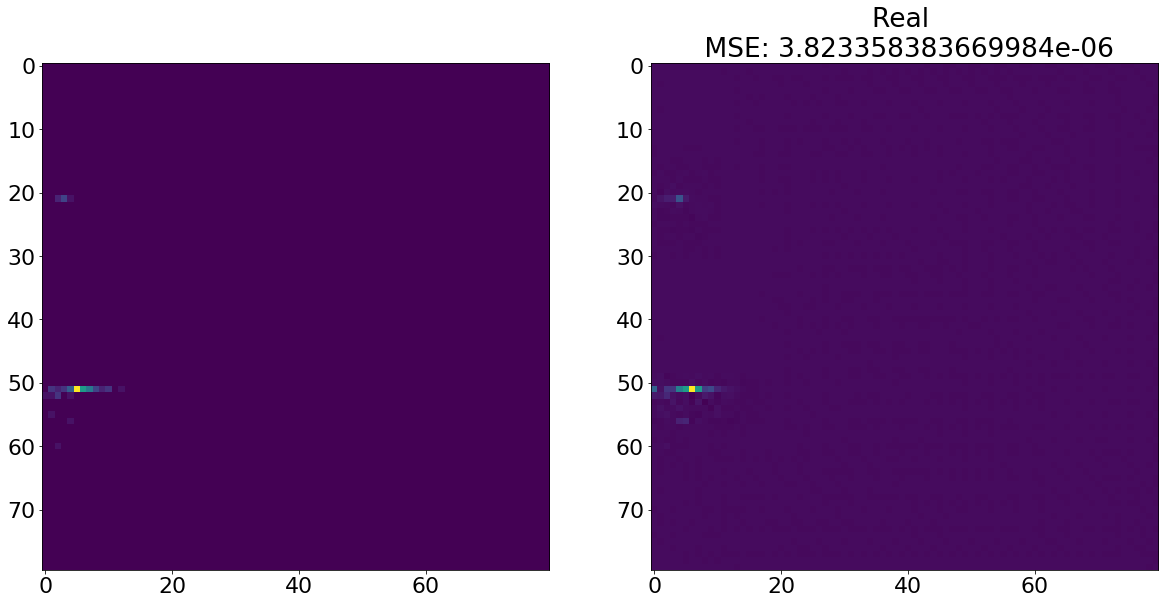

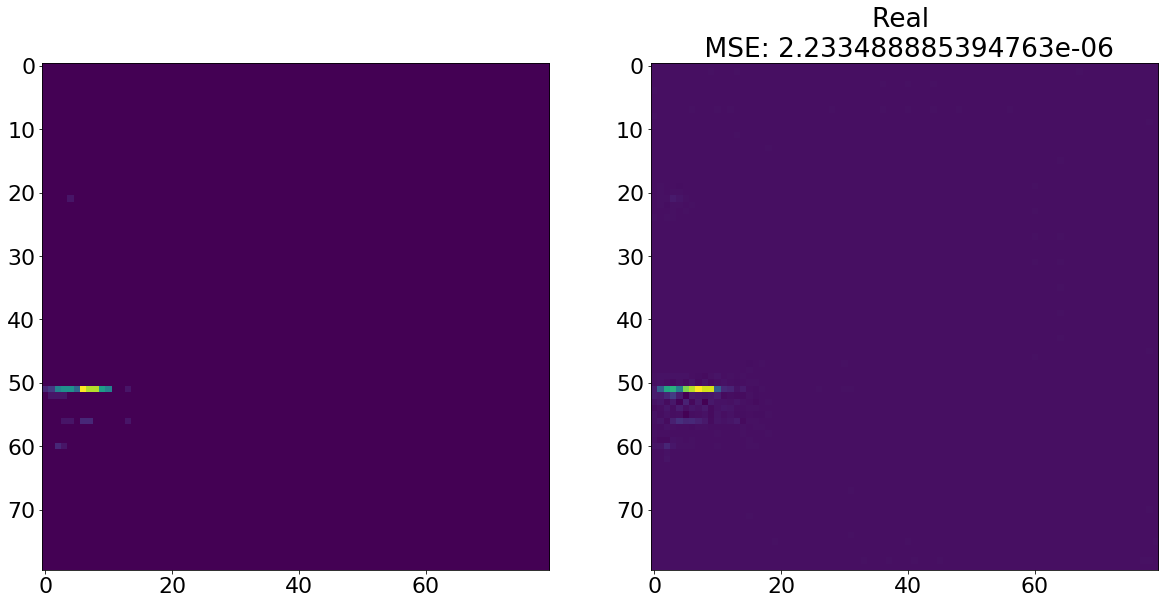

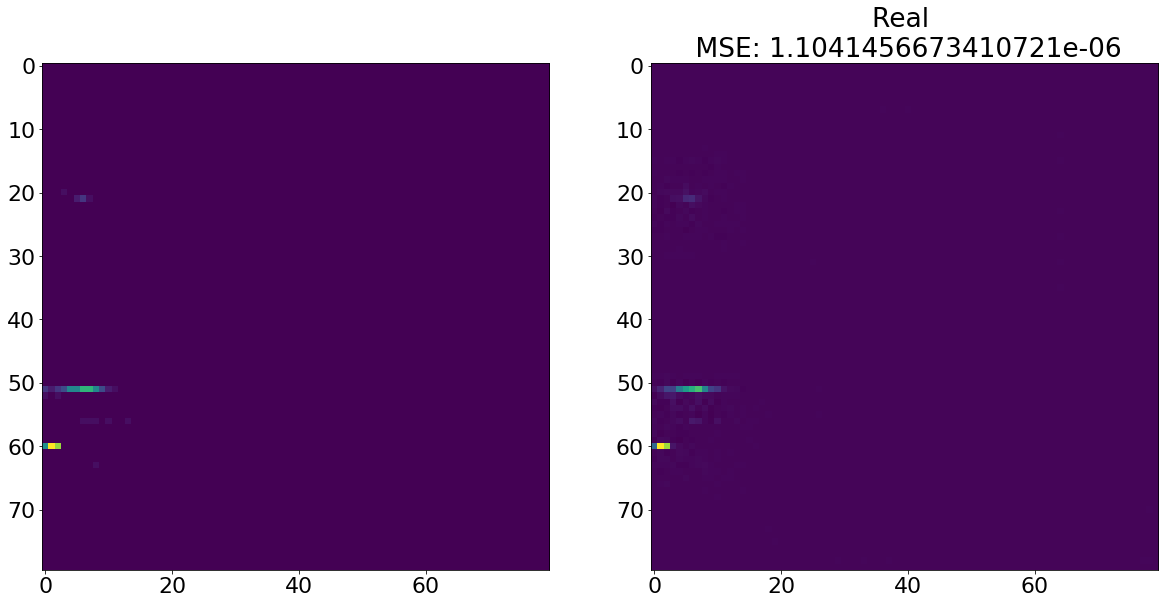

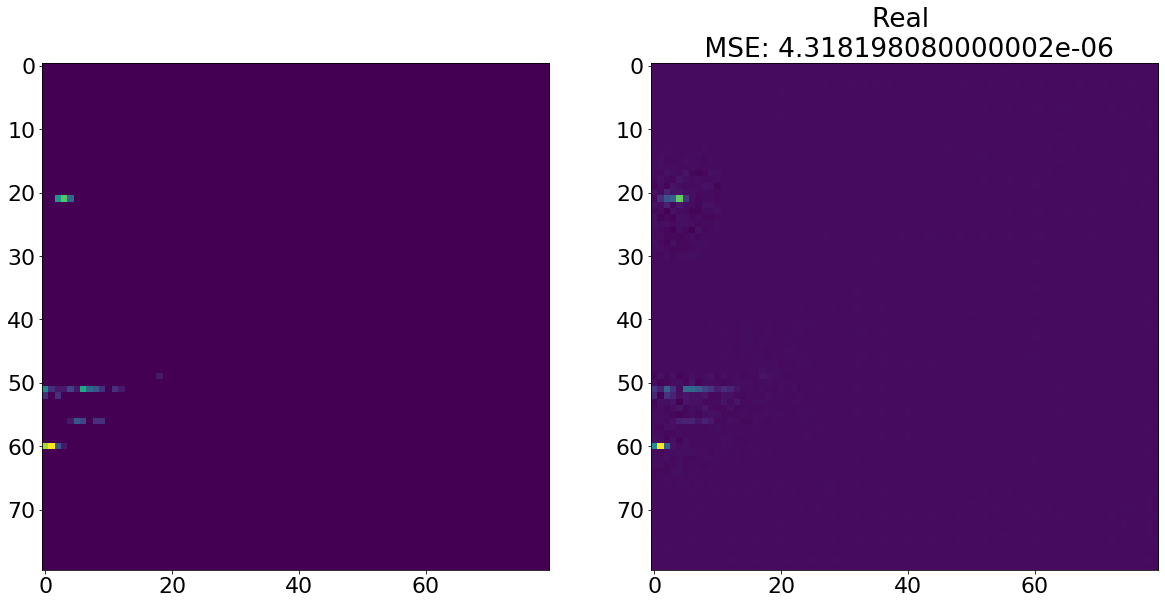

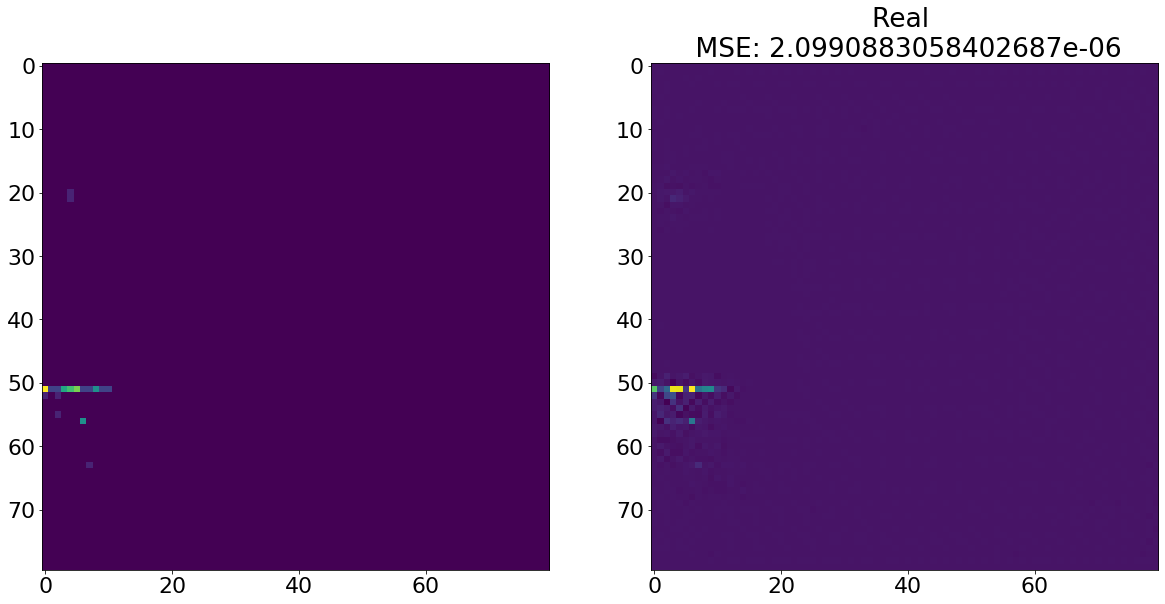

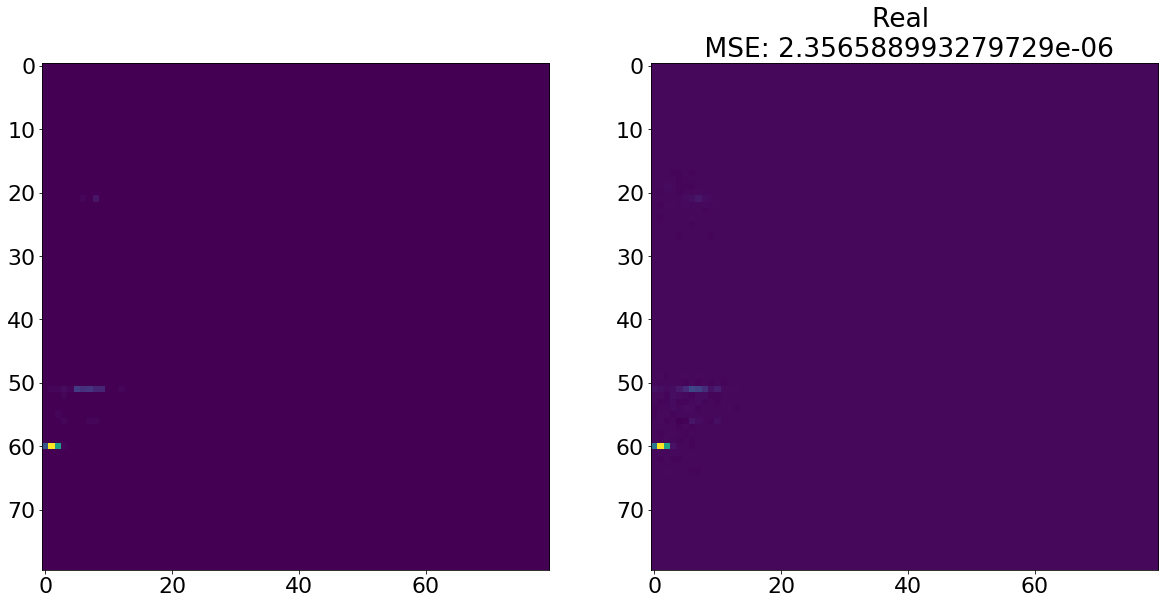

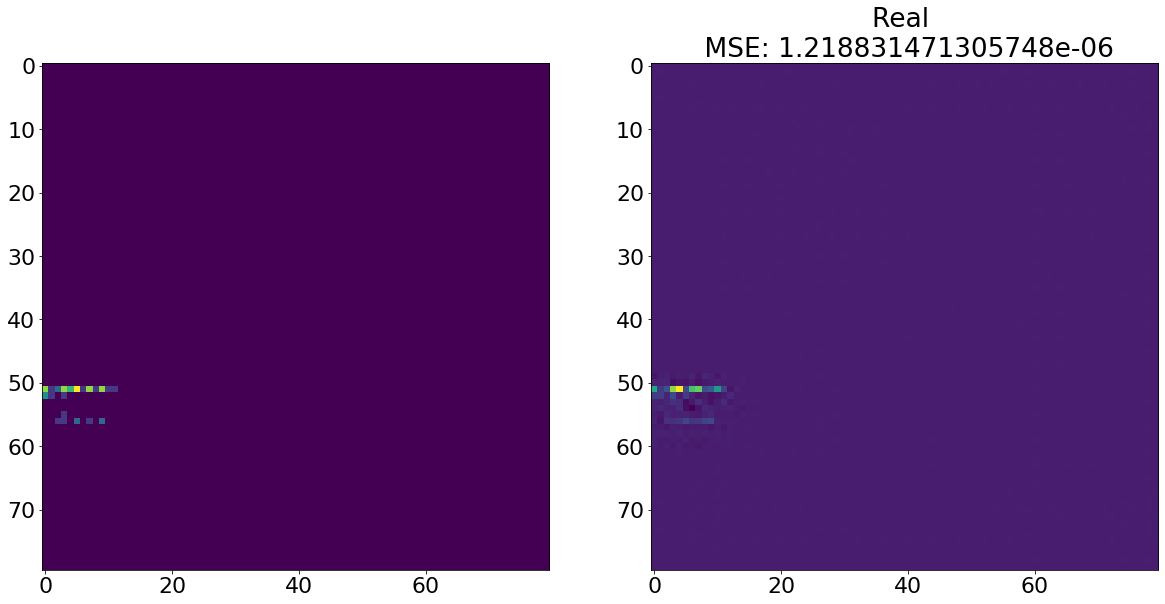

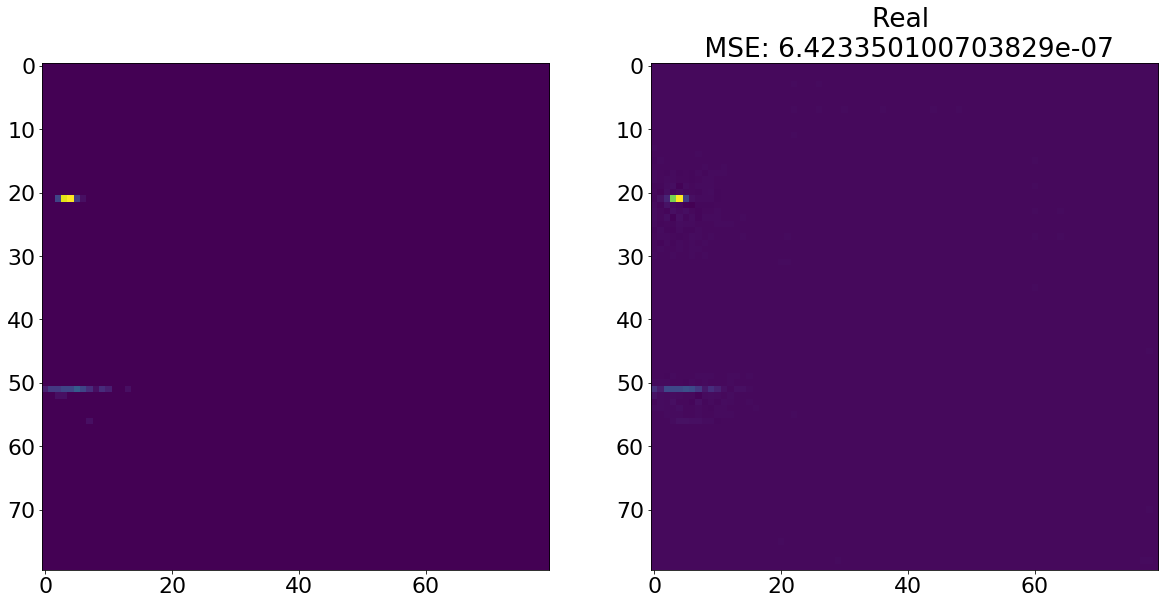

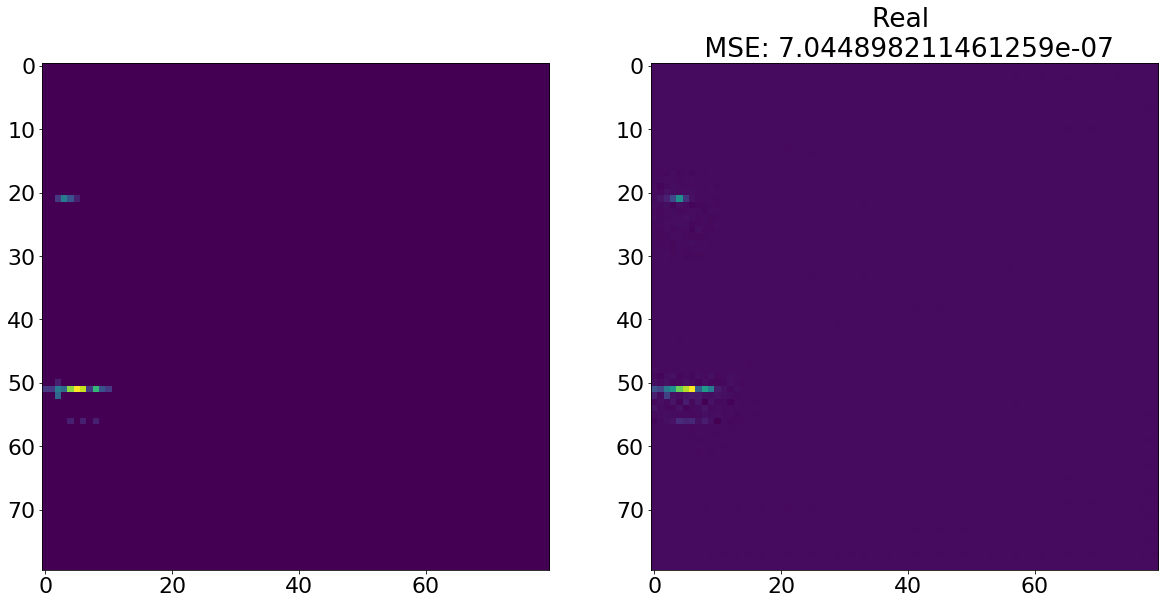

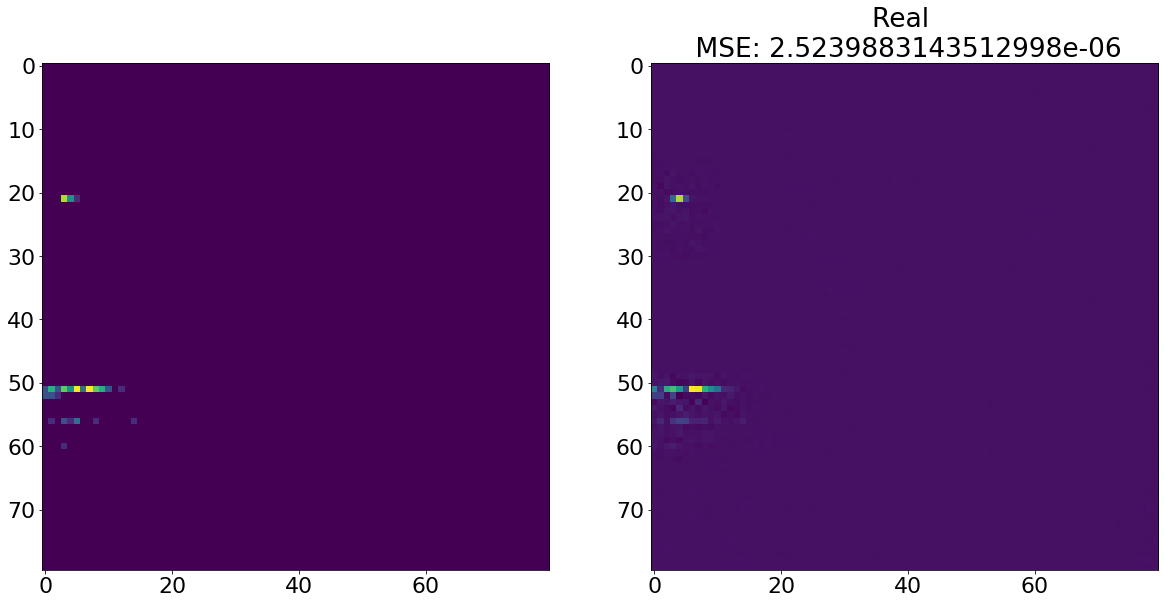

In [9]:
for i in range(len(fakes)-10,len(fakes)):
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[1].imshow(fakes[i,0])
    ax[0].imshow(inputs[i,0])
    ax[1].set_title('Real \n MSE: {}'.format(mean_squared_error(fakes[i,0],inputs[i,0])))
    fig.savefig(outpath + 'images/generatedimages/realfake_{}_{}_{}.png'.format(str(datetime.date.today()),i,tag))

In [10]:
with open(outpath+'/loss/p25_G_losses_{}_ae_{}.pkl'.format(str(datetime.date.today()),tag),'wb') as f:
    pickle.dump(G_losses,f)
with open(outpath+'/loss/p25_D_losses_{}_ae_{}.pkl'.format(str(datetime.date.today()),tag),'wb') as f:
    pickle.dump(D_losses,f)

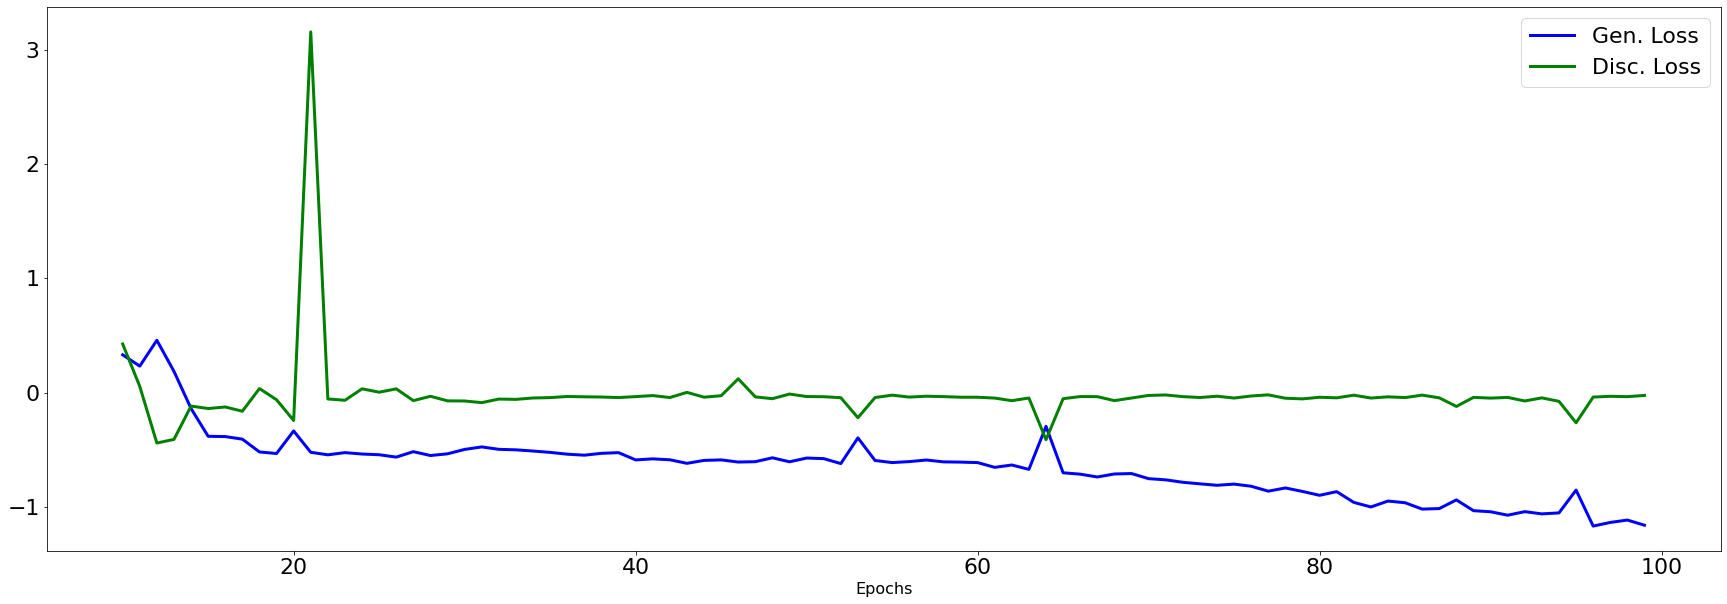

In [11]:
fig,ax=plt.subplots(1,1,figsize=(30,10))
ax.plot(pd.Series(G_losses)[10:],c='b',lw=3)
ax.plot(pd.Series(D_losses)[10:],c='g',lw=3)

ax.legend(['Gen. Loss','Disc. Loss'])
ax.set_xlabel("Epochs",fontsize=16)
fig.savefig(outpath+'/images/fm_losses_{}_{}.png'.format(str(datetime.date.today()),tag))

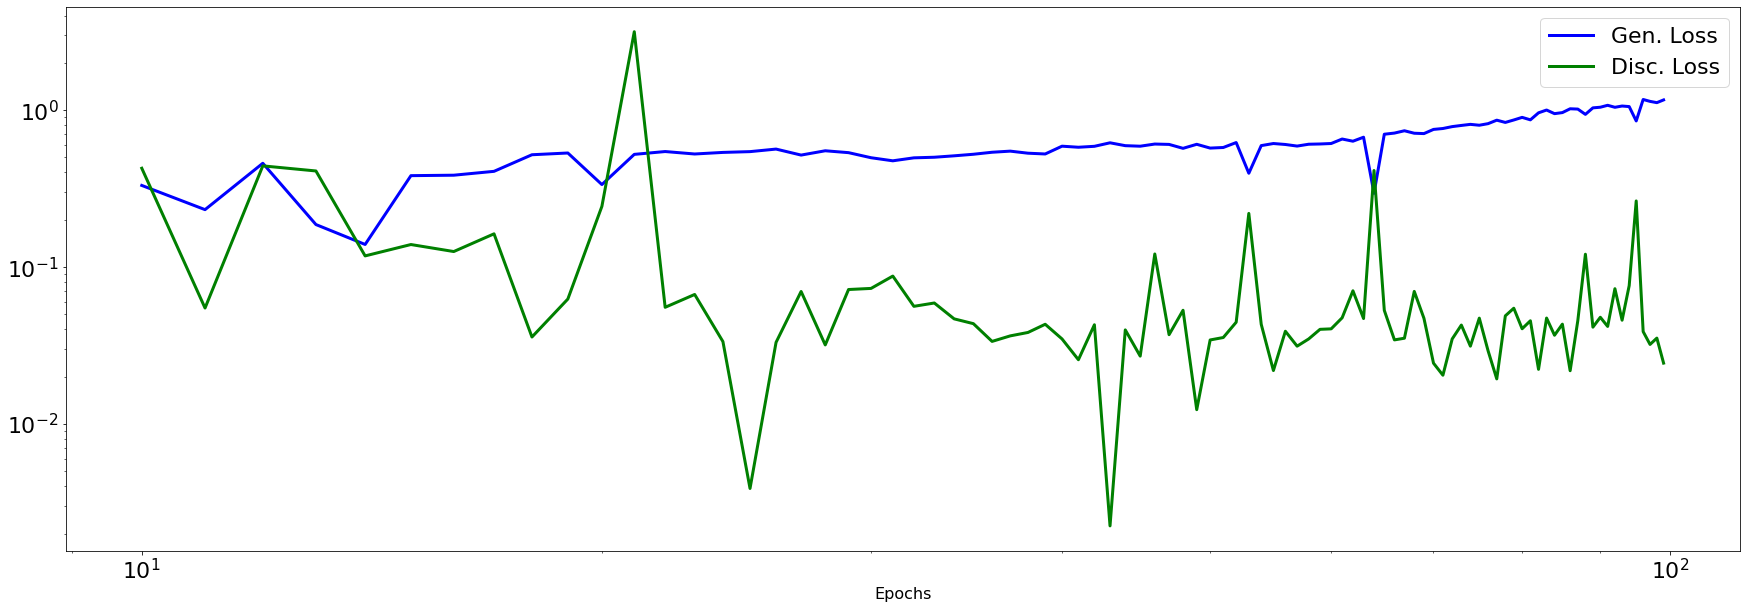

In [12]:
fig,ax=plt.subplots(1,1,figsize=(30,10))
ax.loglog(abs(pd.Series(G_losses)[10:]),c='b',lw=3)
ax.loglog(abs(pd.Series(D_losses)[10:]),c='g',lw=3)

ax.legend(['Gen. Loss','Disc. Loss'])
ax.set_xlabel("Epochs",fontsize=16)
fig.savefig(outpath+'/images/fm_loglog_losses_{}_{}.png'.format(str(datetime.date.today()),tag))